In [2]:
import torch
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib
from sklearn.cluster import KMeans, AgglomerativeClustering
import imageio
import os
import copy

/Users/tristan/miniconda3/envs/deep/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
X = np.array([
    [1,1,1,1,1,1],
    [1,2,1,2,1,2],
    [2,1,2,2,1,1],
    [10,10,10,10,10,10],
    [10,11,10,10,10,10],
    [10,11,9,10,9,10],
    [20,20,20,20,20,20],
    [21,20,19,20,21,21],
    [19,21,19,20,21,20]
])

dataset = torch.tensor(X).unsqueeze(1).to(torch.float)
dataset.shape

torch.Size([9, 1, 6])

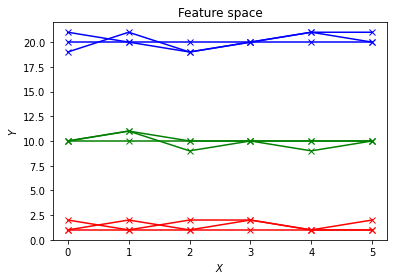

In [4]:
plt.plot(range(6), X[0], marker='x', c='r')
plt.plot(range(6), X[1], marker='x', c='r')
plt.plot(range(6), X[2], marker='x', c='r')
plt.plot(range(6), X[3], marker='x', c='g')
plt.plot(range(6), X[4], marker='x', c='g')
plt.plot(range(6), X[5], marker='x', c='g')
plt.plot(range(6), X[6], marker='x', c='b')
plt.plot(range(6), X[7], marker='x', c='b')
plt.plot(range(6), X[8], marker='x', c='b')
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('Feature space')
plt.show()

In [5]:
class Encoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.cnn = nn.Conv1d(1,1,3,1)
        self.max_pool = nn.MaxPool1d(2,1)
        self.lstm_hidden_dim = 1
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=1,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )

    def forward(self, x):
        x = self.max_pool(F.relu(self.cnn(x)))
        x = x.permute(0, 2, 1)
        x, (_, _) = self.lstm(x)

        x = x[:, :, : self.lstm_hidden_dim] + x[:, :, self.lstm_hidden_dim :]
        x = x.permute(0,2,1)
        return x

class Decoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # Make each time series have 4 elements
        self.upsample = nn.Upsample(size=(4,))
        self.decoder = nn.ConvTranspose1d(1,1,3,1)
    
    def forward(self,x):
        x = self.upsample(x)
        return F.relu(self.decoder(x))


class TAE(nn.Module):
    def __init__(self, encoder, decoder) -> None:
        super().__init__()
        self.encoder = encoder 
        self.decoder = decoder 

    def forward(self, x):
        l = self.encoder(x)
        x_prime = self.decoder(l)
        return l, x_prime


class ClusterLayer(nn.Module):
    def __init__(self, encoder, centroids) -> None:
        super().__init__()
        self.encoder = encoder 
        self.centroids = nn.Parameter(centroids)
    
    def euclidean_distance(self, x, y):
        dists = torch.zeros(9,3)

        for i in range(9):
            d = []
            for j in range(3):
                a = x[i].flatten()
                b = y[j].flatten()
                euc = ((a-b)**2).sum()
                dists[i][j] = euc
        return dists

    def students_t_distribution_kernel(self, x, alpha=1):
        num = torch.pow((1 + x / alpha), -(alpha + 1) / 2)
        denom = num.sum(dim=1).reshape(-1, 1).repeat(1, 3)
        return num / denom

    def target_distribution(self, Q):
        F = Q.sum(dim=0)
        num = (Q ** 2) / F
        denom = num.sum(dim=1).reshape(-1, 1).repeat(1, Q.shape[-1])
        return num / denom

    def forward(self, x):
        l = self.encoder(x)
        D = self.euclidean_distance(l, self.centroids)
        Q = self.students_t_distribution_kernel(D)
        P = self.target_distribution(Q)
        return l, torch.log(Q), torch.log(P), Q, P

In [6]:
def train_TAE(ae, n_epochs, min_lr):
    optimizer = optim.Adam(ae.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    sheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer,
        factor=0.5,
        patience=50,
        threshold=0.01,
        min_lr=min_lr
    )

    latents = []
    losses = [] 

    pbar = tqdm(range(n_epochs))

    for i in pbar:
        l, x_prime = ae(dataset)
        loss = criterion(x_prime, dataset)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sheduler.step(loss.item())

        latents.append(l.detach().numpy())
        losses.append(loss.item())
        
        if i % 100 == 0:
            pbar.set_description(f'{round(loss.item(), 6)}')
    return latents, losses

In [7]:
def euclidean_distance(x, y):
    dists = torch.zeros(9,9)

    for i in range(9):
        d = []
        for j in range(9):
            a = x[i].flatten()
            b = y[j].flatten()
            euc = ((a-b)**2).sum()
            dists[i][j] = euc
    return dists

In [36]:
decoder = Decoder()
encoder = Encoder()
ae = TAE(encoder, decoder)

latents, losses = train_TAE(ae, n_epochs=5000, min_lr=0.001)

6.603338: 100%|██████████| 5000/5000 [00:12<00:00, 408.92it/s] 


In [37]:
l = encoder(dataset).detach().squeeze(1).numpy()

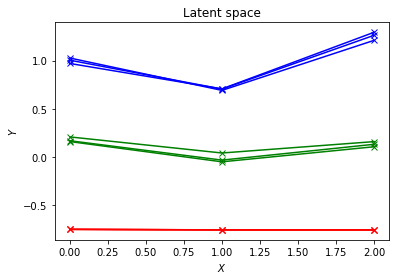

In [38]:
plt.plot(range(3), l[0], marker='x', c='r')
plt.plot(range(3), l[1], marker='x', c='r')
plt.plot(range(3), l[2], marker='x', c='r')
plt.plot(range(3), l[3], marker='x', c='g')
plt.plot(range(3), l[4], marker='x', c='g')
plt.plot(range(3), l[5], marker='x', c='g')
plt.plot(range(3), l[6], marker='x', c='b')
plt.plot(range(3), l[7], marker='x', c='b')
plt.plot(range(3), l[8], marker='x', c='b')
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('Latent space')
plt.show()

In [39]:
latent, x_prime = ae(dataset)
latent = latent.squeeze(1)
similarity_matrix = euclidean_distance(latent, latent)

similarity_matrix = similarity_matrix.detach().numpy()

clustering_assignments = AgglomerativeClustering(
    n_clusters=3, affinity="precomputed", linkage="complete",
).fit_predict(similarity_matrix)

centroids = []
for i in np.unique(clustering_assignments):
    centroid = latent[clustering_assignments == i].mean(dim=0).unsqueeze(0)
    centroids.append(centroid)
centroids = torch.cat(centroids)
centroids = centroids.detach()

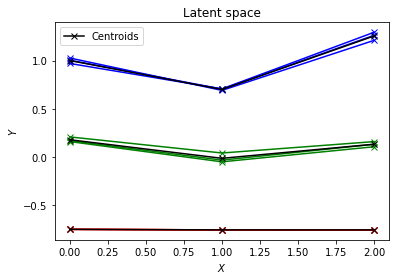

In [40]:
plt.plot(range(3), l[0], marker='x', c='r')
plt.plot(range(3), l[1], marker='x', c='r')
plt.plot(range(3), l[2], marker='x', c='r')
plt.plot(range(3), l[3], marker='x', c='g')
plt.plot(range(3), l[4], marker='x', c='g')
plt.plot(range(3), l[5], marker='x', c='g')
plt.plot(range(3), l[6], marker='x', c='b')
plt.plot(range(3), l[7], marker='x', c='b')
plt.plot(range(3), l[8], marker='x', c='b')
plt.plot(range(3), centroids[0], marker='x', c='black', label='Centroids')
plt.plot(range(3), centroids[1], marker='x', c='black')
plt.plot(range(3), centroids[2], marker='x', c='black')
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('Latent space')
plt.legend()
plt.show()

In [41]:
cl_main = ClusterLayer(encoder=encoder, centroids=centroids)

In [42]:
ce_loss = nn.CrossEntropyLoss()

In [50]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


def fit_DTC(cl, output_name, lr, loss_type):
    optimizer = optim.SGD(cl.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=50, verbose=1)
    mse = nn.MSELoss()
    kl = nn.KLDivLoss(reduction='batchmean', log_target=True)

    filenames = []

    last_loss = float('inf')
    tol = 0.001
    patience_counter = 0
    patience_tol = 1000

    all_losses = []
    all_mse = []
    all_kl = []
    all_ce = []

    pbar = tqdm(range(10000))

    for i in pbar:
        l, log_P, log_Q, Q, P = cl(dataset)
        x_prime = decoder(l)

        mse_loss = mse(dataset, x_prime)
        kl_loss = kl(log_Q, log_P)

        target = F.one_hot(Q.argmax(dim=1), num_classes=3).to(torch.float)

        entropy_loss = ce_loss(Q, target)

        if loss_type == 'ce':
            dtc_loss = mse_loss + 5000 * entropy_loss
        else:
            dtc_loss = mse_loss + kl_loss

        all_losses.append(dtc_loss.item())
        all_mse.append(mse_loss.item())
        all_kl.append(kl_loss.item())
        all_ce.append(entropy_loss.item())

        optimizer.zero_grad()
        dtc_loss.backward()
        optimizer.step()

        
        if i % 100 == 0 and i != 0:
            fig, ax = plt.subplots(2,2)

            ls = [x.flatten().detach() for x in l]
            cents = [x.flatten().detach() for x in cl.centroids]

            ax[0][0].plot(range(len(all_mse)), all_mse)
            ax[0][0].set_xlabel('$Epoch$')
            ax[0][0].set_ylabel('$Loss$')
            ax[0][0].set_title(f'MSE')

            if loss_type != 'ce':
                ax[0][1].plot(range(len(all_kl)), all_kl)
                ax[0][1].set_xlabel('$Epoch$')
                ax[0][1].set_ylabel('$Loss$')
                ax[0][1].set_title(f'KL Divergence Loss')
            else:
                ax[0][1].plot(range(len(all_ce)), all_ce)
                ax[0][1].set_xlabel('$Epoch$')
                ax[0][1].set_ylabel('$Loss$')
                ax[0][1].set_title(f'Cross Entropy Loss')

            ax[1][0].plot(range(3), ls[0], c='r')
            ax[1][0].plot(range(3), ls[1], c='r')
            ax[1][0].plot(range(3), ls[2], c='r')
            ax[1][0].plot(range(3), ls[3], c='g')
            ax[1][0].plot(range(3), ls[4], c='g')
            ax[1][0].plot(range(3), ls[5], c='g')
            ax[1][0].plot(range(3), ls[6], c='b')
            ax[1][0].plot(range(3), ls[7], c='b')
            ax[1][0].plot(range(3), ls[8], c='b')
            ax[1][0].plot(range(3), cents[0], c='black', label='Centroids')
            ax[1][0].plot(range(3), cents[1], c='black')
            ax[1][0].plot(range(3), cents[2], c='black')
            ax[1][0].set_xlabel('$X$')
            ax[1][0].set_ylabel('$Y$')
            ax[1][0].set_title('Latent space')
            ax[1][0].legend()

            ax[1][1].plot(range(len(all_losses)), all_losses)
            ax[1][1].set_xlabel('$Epoch$')
            ax[1][1].set_ylabel('$Loss$')
            ax[1][1].set_title(f'DTC ')

            fig.set_size_inches(25, 15)
            fig.suptitle(f'TAE min lr = 0.01 || DTC lr = {lr}')

            filename = f'temp/img_{i}.png'
            filenames.append(filename)

            # plt.show()
            # 0/0

            plt.savefig(filename)
            plt.close()

            pbar.set_description(f'{round(dtc_loss.item(), 8)}')

        # if abs(last_loss - dtc_loss.item()) < tol:
        #     if patience_counter >= patience_tol:
        #         break
        #     patience_counter += 1
        # else:
        #     last_loss = dtc_loss.item()
        #     patience_counter = 0

        # scheduler.step(dtc_loss.item())
        # all_losses.append(dtc_loss.item())

    # build gif
    with imageio.get_writer(f'{output_name}.gif', mode='I') as writer:
        for filename in filenames:
            image = imageio.v2.imread(filename)
            writer.append_data(image)
            
    # Remove files
    for filename in set(filenames):
        os.remove(filename)

In [86]:
cl = copy.deepcopy(cl_main)
fit_DTC(cl, 'exp_kl', 0.001, loss_type='kl')

2.76614308: 100%|██████████| 20000/20000 [01:34<00:00, 211.48it/s]


In [51]:
cl = copy.deepcopy(cl_main)
fit_DTC(cl, 'exp_ce', 0.000001, loss_type='ce')

3622.54248047: 100%|██████████| 10000/10000 [00:54<00:00, 182.35it/s]
